this problem is define within the book *Reinforcement Learning: An introduction*

you can search the *k-armed bandit problem* for clear definition and explanation.

this project is a fork and added some entended work from 

https://github.com/Mononofu/reinforcement-learning/blob/master/nbandit.py

In [1]:
import abc
#import commands
import functools
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np


class Environment(object):
  __metaclass__ = abc.ABCMeta

  @abc.abstractmethod
  def available_actions(self):
    return []

  @abc.abstractmethod
  def act(self, action):
    return 0.0

## prepare the bandit / environment

In [2]:
class Bandit(Environment): # to define a bandit as an Environment

  def __init__(self, rewards, noise_std):
    '''
        to define an environemnt, that means the reward is settled,
        and the mean time, the settled rewards is defined from the feed from outside(not generated inside a bandit)
    '''
    self.rewards = rewards #the reward vector, array, tensor
    self.n = len(rewards) # the lever the bandit has, n denotes the k when saying k-armed bandit
    self.noise_std = noise_std # in order to confuse the learner / player / agent a little bit, you have to put some noise inside

  def available_actions(self):
    '''
    actually the lever / arm index / number
    '''
    return range(self.n)

  def act(self, action):
    '''
    the agent / player / learner acts on the bandit / environment,
    and the bandit / environment gave back reward for the specific action
    Pay attention to the return statement,
    it gives the current value of the reward based on the action provided and added some noise
    '''
    return self.rewards[action] + random.gauss(0, self.noise_std)

  def __str__(self):
    return 'Bandit(%s, noise_std=%s)' % (self.rewards, self.noise_std)

## prepare a greedy agent

even before the digging of the code, there is a formule to be used inside the code, how to calculate the average of a increasing record.

keeping a list of all the records and do average on the whole record everytime is not computational efficient. instead, you can consider each time a new record coming, you have the following formule to be used:

$Q_{n+1} = \frac{1}{n}\sum_{i=1}^n Reward_i$

> this is how you can do it in each record coming and keeping the record in a list

$Q_{n+1} = \frac{1}{n}[(n-1) * Q_n + Reward_n]$

> the $(n-1)*Q_n$ is to get all the accumulated Q in the $(n-1)_{th}$ turn, and add the new reward, and do the average again.

this equation can derive the following one:

$Q_{n+1} = Q_n + \frac{1}{n}(R_n - Q_n)$

which is actually used in the code below

In [3]:
class GreedyAgent(object):
  '''
  this agent exactly follows its experience and never would take chance to explor
  '''
  def __init__(self, num_actions):
    '''
    it has a vector / array keeping the experience, from the beginning,
    the experice vector is initialized to 0
    and it has a vector to keep to executed time records for each action
    the reason why it is initialized to 1 is this value will be used to do average
    '''
    # action_value_estimates
    self.Q = [0 for _ in range(num_actions)]
    self.action_count = [1 for _ in range(num_actions)]

  def act(self):
    '''
    recall the Q is the vector of its experience
    this is to find the index with which the Q has the greatest value
    '''
    return functools.reduce(lambda a, b: a if self.Q[a] > self.Q[b] else b, range(len(self.Q)))

  def learn(self, action, reward):
    '''
    do average on the action's all known rewards
    '''
    self.Q[action] += 1.0 / self.action_count[action] * (reward - self.Q[action])
    self.action_count[action] += 1 # and to update the executed time of the action

  def __str__(self):
    return 'GreedyAgent'

## prepare a UCB agent

Upper-Confidence-Bound

### define a UCB formule

$A_t \hat{=}argmax_a[Q_t(a) + c\sqrt{\frac{\ln{t}}{N_t(a)}}]$

In [4]:
class UCBAgent(GreedyAgent):
    '''
    the Uppper Confidence Bound agent with denote different possibilities to different potential actions
    '''
    def __init__(self, num_actions, exploration_degree):
        super(UCBAgent, self).__init__(num_actions)
        self.exploration_degree = exploration_degree
        self.num_actions = num_actions
        self.action_taken = 0
        
    def act(self):
        '''
        as defined above the UCB formule
        '''
        self.action_taken += 1
        ucb = [self.Q[action] + self.exploration_degree * math.sqrt(math.log(self.action_taken) / self.action_count[action])
                      if self.action_count[action] != 0 else 'max' for action in range(self.num_actions)]
        if 'max' in ucb:
            return index('max')
        else:
            return functools.reduce(lambda a, b : a if ucb[a] > ucb[b] else b, range(self.num_actions) )
        
    def __str__(self):
        return 'UCB(c = %f)' % self.exploration_degree

## Epsilon agent

In [5]:
class EpsilonGreedyAgent(GreedyAgent):
  '''
  this agent learns exactly as the GreedyAgent from which it extends / inherites
  but the agent acts different from the Greedy one.
  
  it takes chance to explore some other actions.
  '''

  def __init__(self, num_actions, epsilon):
    super(EpsilonGreedyAgent, self).__init__(num_actions)
    self.epsilon = epsilon
    self.num_actions = num_actions

  def act(self):
    '''
    this is where the difference from.
    
    it takes a posibility of about epsilon to explore, mean it will randomly choose an action to go
    '''
    if random.random() < self.epsilon:
      return random.randint(0, self.num_actions - 1)
    else:
      return super(EpsilonGreedyAgent, self).act()

  def __str__(self):
    return 'EpsilonGreedyAgent(epsilon=%f)' % self.epsilon

## Prepare a softmax / The Bandit Gradient Algorithm / Stochastic Gradient Ascent agent

### this is how the probablities of the actions computed:

$Pr\{A_t=a\} \dot{=} \pi_t(a) \hat{=} \frac{e^{H_t(a)}}{\sum_{b=1}^k{e^{H_t(b)}}}$

see from the formule above, the action is chosen based on the probabilities, which is actually based on the relative relation $H_t(A)$

### then how to update the *relative relation* $H_t(A)$

there are two different formule, for updating the *preference $H_t(A)$*

$H_{t+1}(A_t) \dot{=} H_t(A_t) + \alpha(R_t - \overline{R_t})(1-\pi_t(A_t)), -------> for A_t$ 

$H_{t+1}(a) \dot{=} H_t(a) - \alpha(R_t - \overline{R_t})\pi_t(a) -------> for      \ a \ne A_t$

In [6]:
class SoftmaxAgent(GreedyAgent):
    '''
    an agent that uses the above formules as learn or act basis
    '''
    def __init__(self, num_actions, alpha_step_size):
        super(SoftmaxAgent, self).__init__(num_actions)
        self.alpha_step_size = alpha_step_size
        self.r_mean = 0
        self.action_taken = 0
        self.Preference = [0 for _ in range(num_actions)]
        self.num_actions = num_actions
        
    def act(self):
        if self.action_taken == 0:
            self.Probs = [1.0 / (self.num_actions)] * self.num_actions
            return 0
        
        pre_sum = sum(math.exp(pre) for pre in self.Preference)
        self.Probs = [math.exp(pre) / pre_sum for pre in self.Preference]
        
        return functools.reduce(lambda a, b: a if self.Probs[a] > self.Probs[b] else b, range(self.num_actions))
    
    def learn(self, action, reward):
        self.r_mean += 1. / (self.action_taken + 1) * (reward - self.r_mean)
        for each_action in range(self.num_actions):
            if action != each_action:
                self.Preference[each_action] -= self.alpha_step_size*(reward - self.r_mean)*self.Probs[each_action]
            else:
                self.Preference[action] += self.alpha_step_size*(reward - self.r_mean)*(1 - self.Probs[action])
                
        self.action_taken += 1
        
    def __str__(self):
        return 'Softmax(alpha=%f)' % self.alpha_step_size
        

## prepare a testBed class

In [7]:
class Testbed(object):

  def __init__(self, environment_fn, agent_fns):
    '''
    to prepare a testbed, you will have to provide both environment / bandir and agents / learner / player
    but instead of provide a instantiated instance from a class, provide a method from which can be used to instantiate a instance
    '''
    self.environment_fn = environment_fn # a method used to instantiate a bandit
    self.agent_fns = agent_fns # a series of methods used to instantiate a series of players

  def evaluate(self, num_episodes, episode_length):
    '''
    @param num_episodes: indicates how many time the case should be run
    @param episode_length: indicates inside a episode, how many rounds a player can play / run
    '''
    plt.ion()
    x = range(episode_length) # indicates the x axis in the figure
    self.rewards = [
      [0 for _ in range(episode_length)] for _ in self.agent_fns
    ] 
    # form a 3X1000(num_agents X num_episode_steps) matrix / array 
    # can be used to buffer the averaged rewards from every agent in every step
    # the averaged reward from every episode
    self.fig = plt.figure()
    ax = self.fig.add_subplot(111)
    ax.set_ylim([0, 1.6])

    # Create some fake agents just for the labels.
    environment = self.environment_fn()
    agents = [f(len(environment.available_actions())) for f in self.agent_fns]
    self.lines = [ax.plot(x, rewards, '-', label=str(agent))[0] for rewards, agent in zip(self.rewards, agents)]
    ax.legend(loc=8)

    start = time.time()
    mse_all = [0 for _ in self.agent_fns]
    for episode in range(num_episodes):
      environment = self.environment_fn() # initialize a new bandit in each episode / round
      agents = [f(len(environment.available_actions())) for f in self.agent_fns] # and initializes multiple agents which were to play
      for step in range(episode_length): # for every step in an episode
        for i, agent in enumerate(agents): # for every agent and its index
          action = agent.act() # agent act based on its experience and bold
          reward = environment.act(action) # bandit gave back the reward based on the player's action, the reward will contain some noise
          agent.learn(action, reward) # the agent learns from the reward
          self.rewards[i][step] += ((1.0 / (episode + 1)) * (reward - self.rewards[i][step]))
          # do average on the know rewards

      if episode and episode % 20 == 0:
        for line, rewards in zip(self.lines, self.rewards):
          line.set_ydata(rewards)
        self.fig.canvas.draw()

      if episode and episode % 100 == 0:
        end_rewards = ', '.join(['%s: %0.2f' % (a, r[-1]) for a, r in zip(agents, self.rewards)])
        eps = episode / (time.time() - start)
        print('Episode %d: ' % episode)
        print('\t Performace %s (%.2f e/s)' % (end_rewards, eps))
        
      
        
      # evaluating the performace of the learning ability
      env_rewards = np.array(environment.rewards)
      agents_exp = np.array([agent.Q for agent in agents])
      mse_s = ((env_rewards - agents_exp)**2).mean(axis=1)
      mse_all = [mse_all[i] + 1. / (episode + 1) * (v - mse_all[i]) for i, v in enumerate(mse_s)]
    
    print( 'MSE %s' % ', '.join(['%s: %0.4f' % (agent_name, agent_mse) for agent_name, agent_mse in zip(agents, mse_all)]))

### explanation about the MSE of the experience and the rewards from bandit
you don't really need care much about the MSE result.

**Because the goal of the learner is to get the greatest reward accumulatively, not to get the most accurate guess of the bandit reward**

Episode 100: 
	 Performace GreedyAgent: 0.96, EpsilonGreedyAgent(epsilon=0.100000): 1.43, UCB(c = 2.000000): 1.67, Softmax(alpha=0.050000): 1.31 (22.91 e/s)
Episode 200: 
	 Performace GreedyAgent: 0.99, EpsilonGreedyAgent(epsilon=0.100000): 1.35, UCB(c = 2.000000): 1.52, Softmax(alpha=0.050000): 1.20 (23.03 e/s)
Episode 300: 
	 Performace GreedyAgent: 0.98, EpsilonGreedyAgent(epsilon=0.100000): 1.33, UCB(c = 2.000000): 1.54, Softmax(alpha=0.050000): 1.13 (23.12 e/s)
Episode 400: 
	 Performace GreedyAgent: 0.99, EpsilonGreedyAgent(epsilon=0.100000): 1.36, UCB(c = 2.000000): 1.54, Softmax(alpha=0.050000): 1.14 (23.14 e/s)
Episode 500: 
	 Performace GreedyAgent: 1.02, EpsilonGreedyAgent(epsilon=0.100000): 1.37, UCB(c = 2.000000): 1.56, Softmax(alpha=0.050000): 1.15 (23.16 e/s)
Episode 600: 
	 Performace GreedyAgent: 1.03, EpsilonGreedyAgent(epsilon=0.100000): 1.39, UCB(c = 2.000000): 1.53, Softmax(alpha=0.050000): 1.17 (23.21 e/s)
Episode 700: 
	 Performace GreedyAgent: 1.03, EpsilonGreed

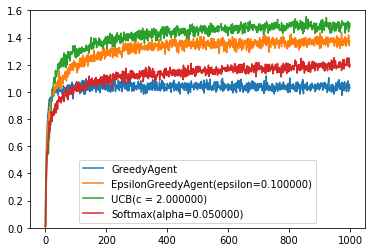

In [8]:
testbed = Testbed(
    environment_fn=lambda: Bandit([random.gauss(0, 1) for _ in range(10)], 1),
    agent_fns=[
        lambda n: GreedyAgent(n),
        lambda n: EpsilonGreedyAgent(n, 0.1),
        lambda n: UCBAgent(n, 2),
        lambda n: SoftmaxAgent(n, 0.05)
    ])
testbed.evaluate(num_episodes=2000, episode_length=1000)